YOLO11x summary: 631 layers, 56,966,176 parameters, 0 gradients, 196.0 GFLOPs


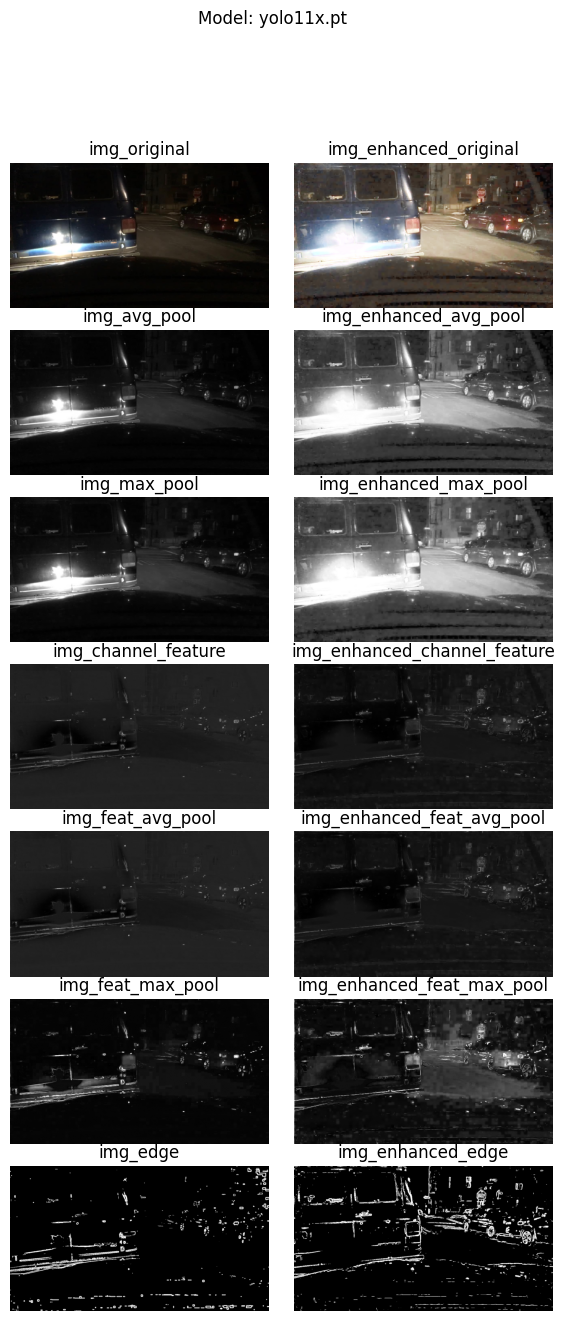

YOLO11n summary: 319 layers, 2,624,080 parameters, 0 gradients, 6.6 GFLOPs


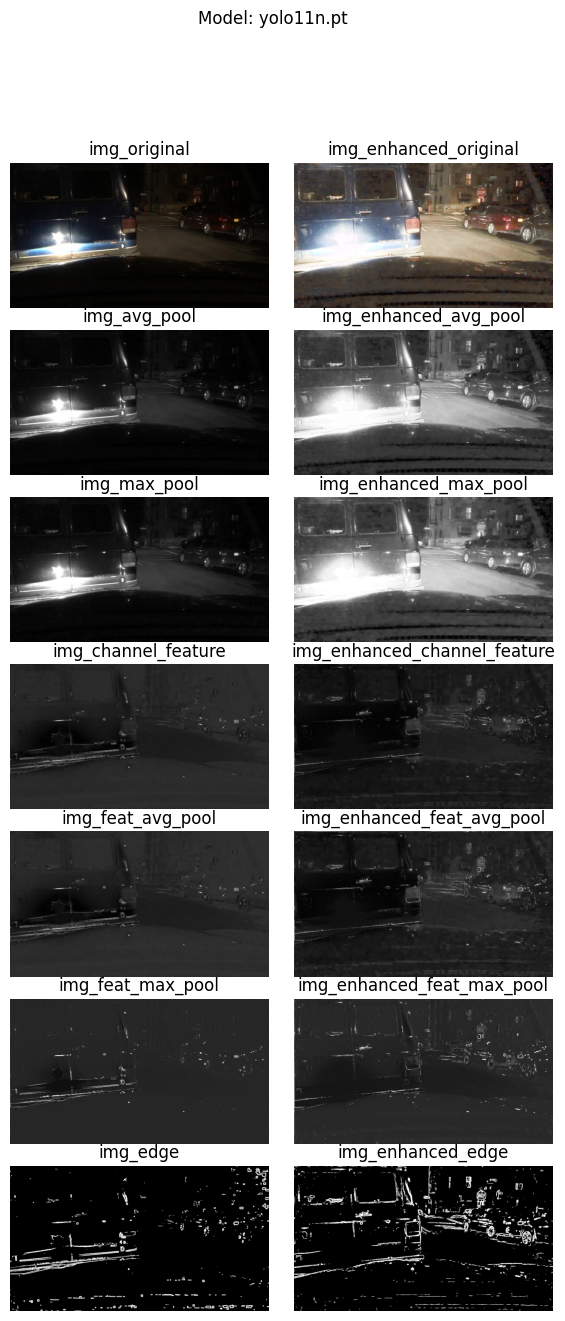

YOLO11n summary: 319 layers, 2,592,180 parameters, 0 gradients, 6.5 GFLOPs


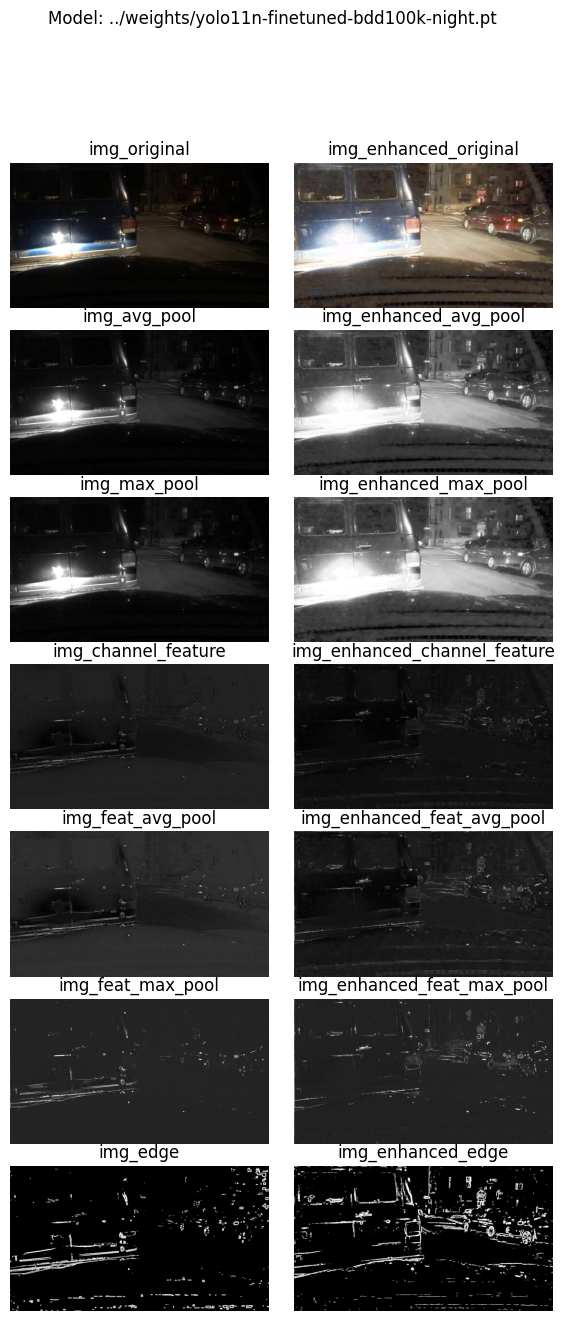

In [ ]:
from ultralytics import YOLO
import torch
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob


def get_edge_map(img):
    # Pre-blur with a small Gaussian kernel to reduce noise
    gray = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    blurred = cv2.GaussianBlur(gray, (3, 3), 0)

    # Apply the Scharr operator for a more sensitive edge detection
    grad_x = cv2.Scharr(blurred, cv2.CV_64F, 1, 0)
    grad_y = cv2.Scharr(blurred, cv2.CV_64F, 0, 1)
    scharr_edges = np.sqrt(grad_x**2 + grad_y**2)

    # Normalize the edge map to [0,1]
    edge_norm = cv2.normalize(scharr_edges, None, 0, 1, cv2.NORM_MINMAX)

    # Optional: threshold to obtain higher contrast edges
    _, edge_thresh = cv2.threshold((edge_norm * 255).astype(np.uint8), 30, 255, cv2.THRESH_BINARY)
    return edge_thresh

def get_img_features_pools_edges(_model, _img):
    _blocks = _model.model.model[:1]
    _img = cv2.imread(_img)
    _image_tensor = torch.tensor(_img, dtype=torch.float32)
    _image_tensor = _image_tensor / 255.0 # normalize the image
    _image_tensor = _image_tensor.unsqueeze(0) # add batch dimension
    _image_tensor = _image_tensor.permute(0, 3, 1, 2) # change the order of the dimensions
    _img_recolored = cv2.cvtColor(_img, cv2.COLOR_BGR2RGB)
    _features = _blocks(_image_tensor)
    _img_edge = get_edge_map(_img_recolored)
    _img_resized = cv2.resize(_img_recolored, (_features[0].shape[2], _features[0].shape[1])) # resize the image to the feature map size
    _avg_pool_img_resized_downsampled = np.mean(_img_resized, axis=2)
    _max_pool_img_resized_downsampled = np.max(_img_resized, axis=2)
    _feature_map = _features[0].detach().cpu().numpy()
    _channel_feature = np.sum(_feature_map, axis=0) # sum all the channels
    _avg_pool_channel_feature = np.mean(_feature_map, axis=0)
    _avg_pool_channel_feature = np.clip(_avg_pool_channel_feature, 0, 5)
    _max_pool_channel_feature = np.max(_feature_map, axis=0)
    _max_pool_channel_feature = np.clip(_max_pool_channel_feature, 0, 20)
    return _img_recolored, _avg_pool_img_resized_downsampled, _max_pool_img_resized_downsampled, _channel_feature, _avg_pool_channel_feature, _max_pool_channel_feature, _img_edge

# loss
# avg_pool_loss = F.mse_loss(torch.tensor(avg_pool_channel_feature), torch.tensor(avg_pool_img_resized_downsampled))

def visualize_features(_model, images):
    images = [img, img_enhanced]

    # img_recolored, avg_pool_img_resized_downsampled, max_pool_img_resized_downsampled, channel_feature, avg_pool_channel_feature, max_pool_channel_feature, img_edge = get_img_features_pools_edges(model, img)
    #img_enhanced_recolored, _, _, channel_feature_enhanced, _, _, img_enhanced_edge = get_img_features_pools_edges(model, img_enhanced)

    img1_output = get_img_features_pools_edges(_model, images[0]) # normal
    img2_output = get_img_features_pools_edges(_model, images[1]) # enhanced

    names = ["img", "img_enhanced"]
    outputs = [img1_output, img2_output]
    output_labels = ["original", "avg_pool", "max_pool", "channel_feature", "feat_avg_pool", "feat_max_pool", "edge"]

    fig, axs = plt.subplots(len(outputs[0]), len(outputs), figsize=(7, 15))
    # title model name
    fig.suptitle(f"Model: {_model.model_name}")
    plt.subplots_adjust(wspace=0.1, hspace=0.1)  # Adjust horizontal and vertical spacing

    for i, output in enumerate(outputs):
        for j, feature in enumerate(output):
            axs[j][i].imshow(feature, cmap='gray')
            axs[j][i].axis('off')
            axs[j][i].set_title(f"{names[i]}_{output_labels[j]}")

    plt.show()


############################################################################################################

# target_checkpoint = "../weights/yolo11n-finetuned-bdd100k-night.pt"
target_checkpoints = ["yolo11x.pt", "yolo11n.pt", "../weights/yolo11n-finetuned-bdd100k-night.pt"]

for target_checkpoint in target_checkpoints:
    model = YOLO(target_checkpoint)
    model.info()
    input_width = 640
    input_height = 384

    image_index = 28

    bddk_images = glob.glob("../../yolo-testing/datasets/bdd128_DLN/images/train/*.jpg")
    img = bddk_images[image_index]
    name = img.split("/")[-1]
    img_enhanced = f"../../yolo-testing/datasets/bdd128_DLN/images_enhanced_VOC_LOL/train/{name[:-4]}_enhanced.png"

    visualize_features(model, [img, img_enhanced])